# Rossman Store Sales Analysis
This analysis is based on the Kaggle data challenge to forecast Rossman Store's sales using store, promotion, and competitor data. This projects consists of three parts:

#### Part A - Exploratory Data Analysis  
#### Part B - Time Series Analysis & Predictive Modelling 
#### Part C - Results & Conclusions


In [1]:
# Import required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
import warnings

# statistics
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame

In [2]:
# Importing store data
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
# Importing train data
train = pd.read_csv('train.csv', index_col='Date', parse_dates = True)
train.head()

C:\Users\Admin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


## Part A - Exploratory Data Analysis (EDA)

In [4]:
# Checking train data
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [5]:
train.shape

(1017209, 8)

Our training data has 1M+ observations of sales data over the year of approximately 2 years (2013-2015). This is a time series data i.e an ordered sequence of values of a variable (here Sales) at equally spaced time intervals (daily, weekly, monthly, yearly). Let's do some feature engineering to make it easier for analysis.

In [6]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

<ipython-input-6-f08f9bc5e74a>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train['WeekOfYear'] = train.index.weekofyear


In [7]:
# Checking train data again
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [8]:
# Checking data when the stores were closed
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


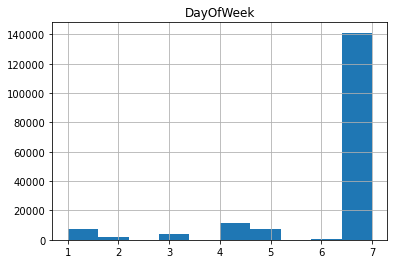

In [9]:
# Checking days when the stores were closed
train_store_closed.hist('DayOfWeek');

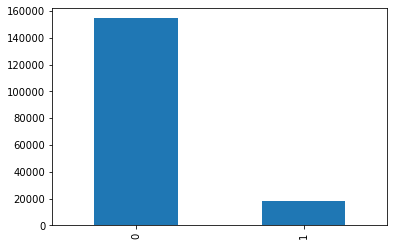

In [10]:
# Checking whether there was a school holiday when the store was closed
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

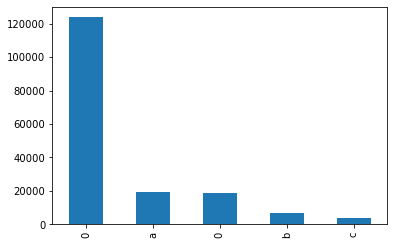

In [11]:
# Checking whether there was a state holiday when the store was closed
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

We can see from the above plot that stores were mostly closed on 7th day i.e Sunday and it makes sense. On other days, they were closed because of a school holiday or/and a state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None).


In [12]:
# Checking missing values in train set - no missing value
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [13]:
# No. of days with closed stores
train[(train.Open == 0)].shape[0]

172817

In [14]:
# No. of days when store was opened but zero sales - might be because of external factors or refurbishmnent
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [15]:
# Checking store data
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [16]:
# Checking missing values in store data 
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Only 3 observations have 'Competition Distance' missing. This is probably because someone didn't enter the information in the system. It's safe to replace these missing values with the median. We can't use the same approach with competition's existence (month and year) as it doesn't make sense. It is better to replace it with 0 (i.e launched recently). We'll also impute the missing values in promo with 0 as no information about promo is avaialable.

In [17]:
# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [18]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [19]:
# Joining the tables
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [20]:
# Distribution of sales and customers across store types
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

<ipython-input-20-96b1899e87f0>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)


,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


Let's see the stores which are closed or have zero sales. 

In [21]:
# Closed and zero-sales obseravtions
train_store_joined[(train_store_joined.Open ==0) | (train_store_joined.Sales==0)].shape

(172871, 22)

So, we have 172,871 observations when the stores were closed or have zero sales. We can drop these rows in order to do data analysis but we can still keep them for predictive modelling because our models will be able to understand the trend behind it.

In [22]:
# Open & Sales >0 stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]

From above table, we can see that Store of type 'a' and 'd' have the highest total sales but stores of type 'c' and 'b' have the highest sale per customer. 

### Correlation Analysis

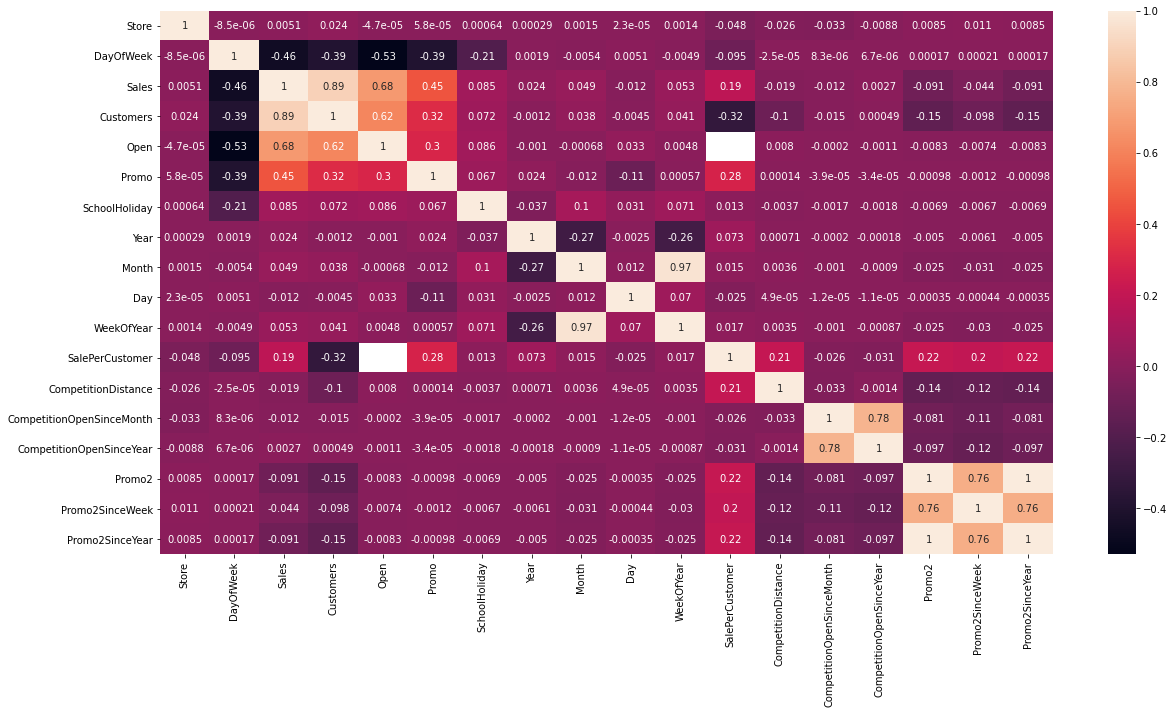

In [23]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True);

We can see a strong positive correlation between the amount of Sales and Customers visiting the store. We can also observe a positive correlation between a running promotion (Promo = 1) and number of customers.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


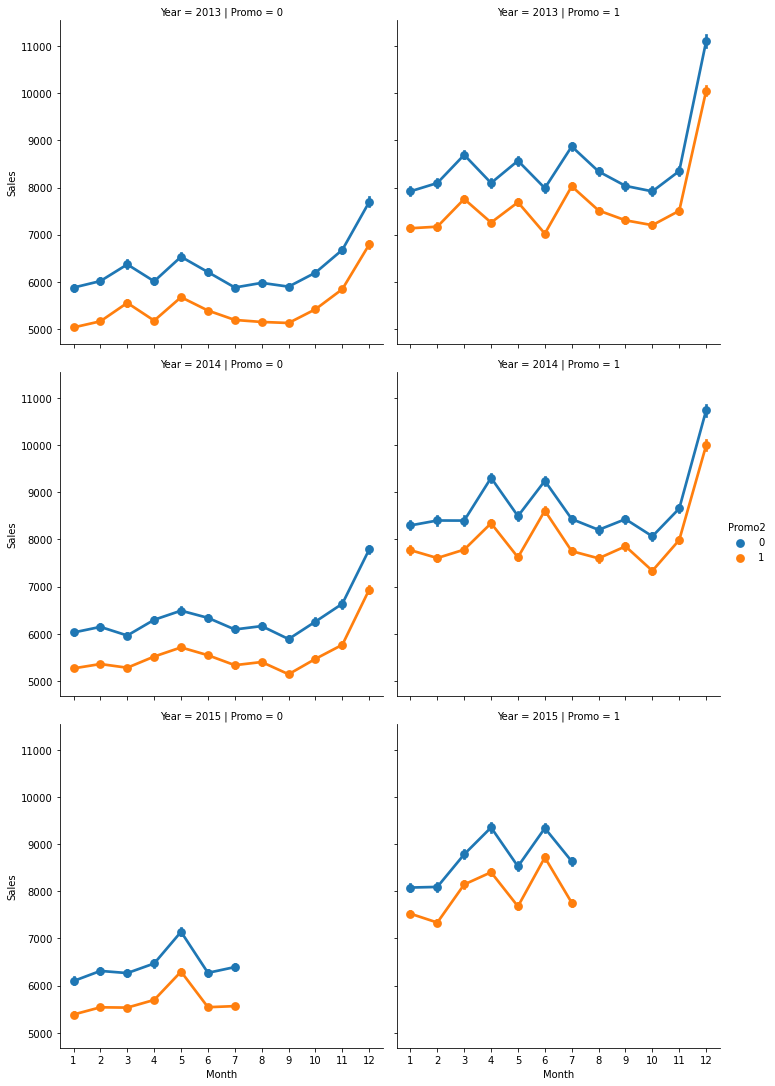

In [24]:
# Sales trend over the months
sns.factorplot(data = train_store_joined_open, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               hue = 'Promo2',
               row = "Year"
             );

We can see from the above trends that sales tend to spike in November and December. So, there is a seasonality factor present in the data.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


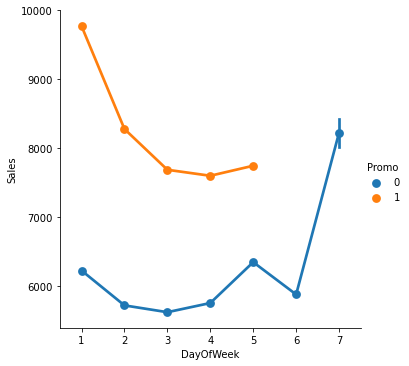

In [25]:
# Sales trend over days
sns.factorplot(data = train_store_joined_open, x = "DayOfWeek", y = "Sales", hue = "Promo");

We can see from the trend that there are no promotions on the weekends i.e Saturday and Sunday, which makes sense as stores want to earn a maximum profit during the time when people do their house chores. The sales tend to increase on Sunday because people shop during the weekend. We can also see that the maximum sale happens on Mondays when there are promotional offers.

### Conclusions of EDA

a) The most selling and crowded StoreType is A. <br>

b) StoreType B has the highest Sale per Customer.<br>

c) Customers tends to buy more on Mondays when there are ongoing promotional offers and on Thursdays/Fridays when there is no promotion at all. <br>

d) Second promotion (Promo2) doesn't seem to contribute in the increase of sales. 

## Part B - Time Series Analysis & Predictive Modelling 

### Time Series Analysis

For Time Series Anlaysis , we will consider one store from each store type a , b , c , d that will represent their respective group. It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.

In [26]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

### Stationarity of Time Series 
In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time. 

There are 2 ways to test the stationarity of time series <br>
 Dicky - Fuller test: Statistical test

a) Rolling Mean: A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slid across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.

b) Dicky -Fuller test: This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [27]:
pd.DataFrame(sales_a.head())

,Sales
Date,
2015-07-31,6064.0
2015-07-30,5567.0
2015-07-29,6402.0
2015-07-28,5671.0
2015-07-27,6627.0


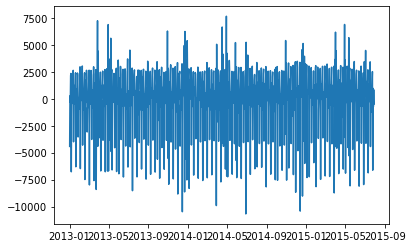

In [28]:
plt.plot(sales_a.diff())

In [29]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    df = timeseries.copy()
    
    df_testing = pd.DataFrame(df.diff()).dropna()
    
    plt.plot(df_testing.diff())
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(df_testing, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

Results of Dickey-Fuller Test:
ADF Statistic: -12.307837
p-value: 0.000000
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


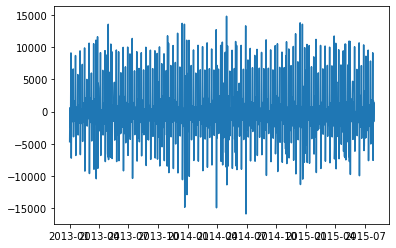

In [30]:
# Testing stationarity of store type a
test_stationarity(sales_a)

Results of Dickey-Fuller Test:
ADF Statistic: -11.026030
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


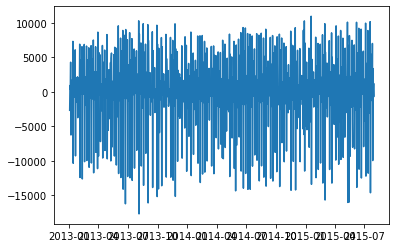

In [31]:
#Testing stationarity of store type b
test_stationarity(sales_b)

Results of Dickey-Fuller Test:
ADF Statistic: -11.490967
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


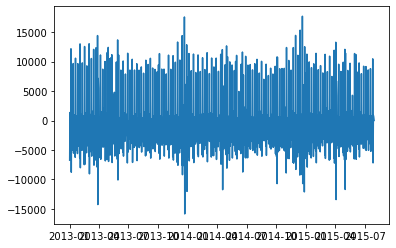

In [32]:
#Testing stationarity of store type b
test_stationarity(sales_c)

Results of Dickey-Fuller Test:
ADF Statistic: -12.672240
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


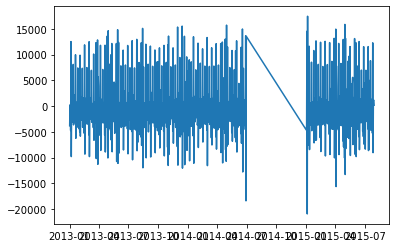

In [33]:
#Testing stationarity of store type d
test_stationarity(sales_d)

In [34]:
# Plotting seasonality and trend
def plot_timeseries(timeseries,StoreType):
    
    sales0 = timeseries.copy()
    
    sales = pd.DataFrame(sales0.diff()).dropna()

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

<ipython-input-34-c7deea240696>:12: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=365)


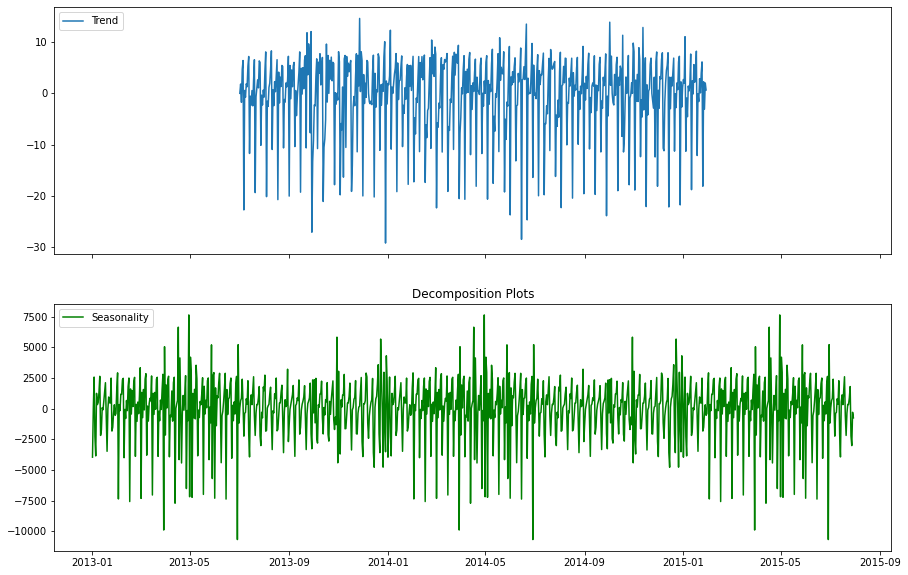

In [35]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

<ipython-input-34-c7deea240696>:12: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=365)


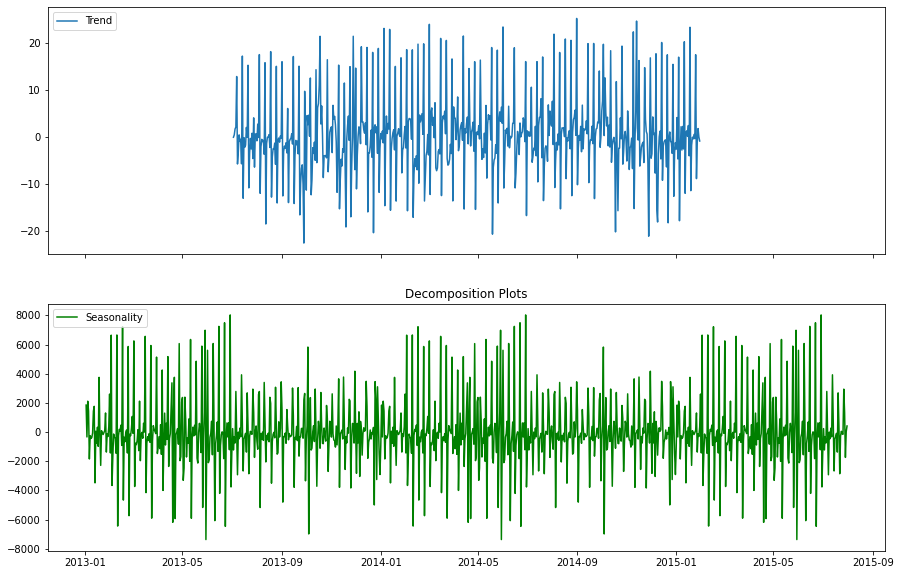

In [36]:
# Plotting seasonality and trend for store type b
plot_timeseries(sales_b,'b')

<ipython-input-34-c7deea240696>:12: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=365)


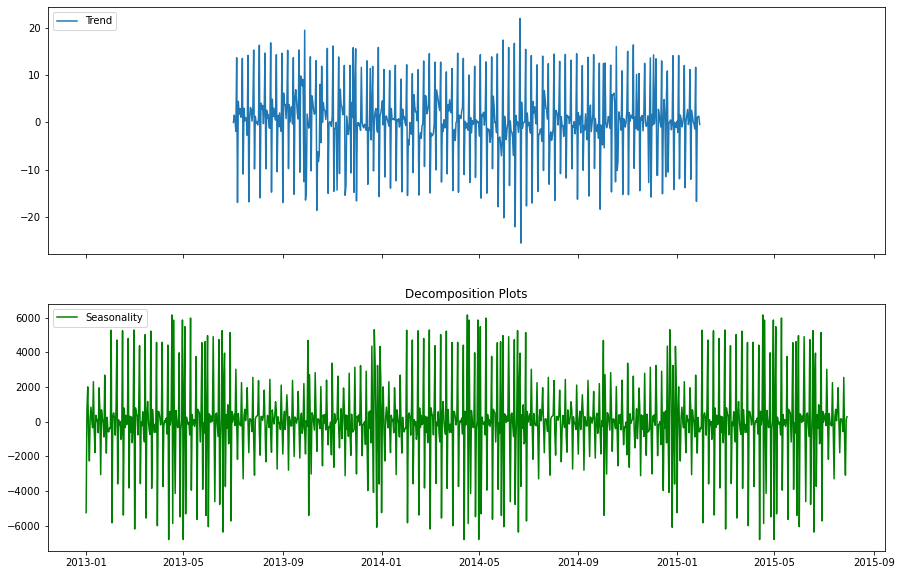

In [37]:
# Plotting seasonality and trend for store type c
plot_timeseries(sales_c,'c')

<ipython-input-34-c7deea240696>:12: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=365)


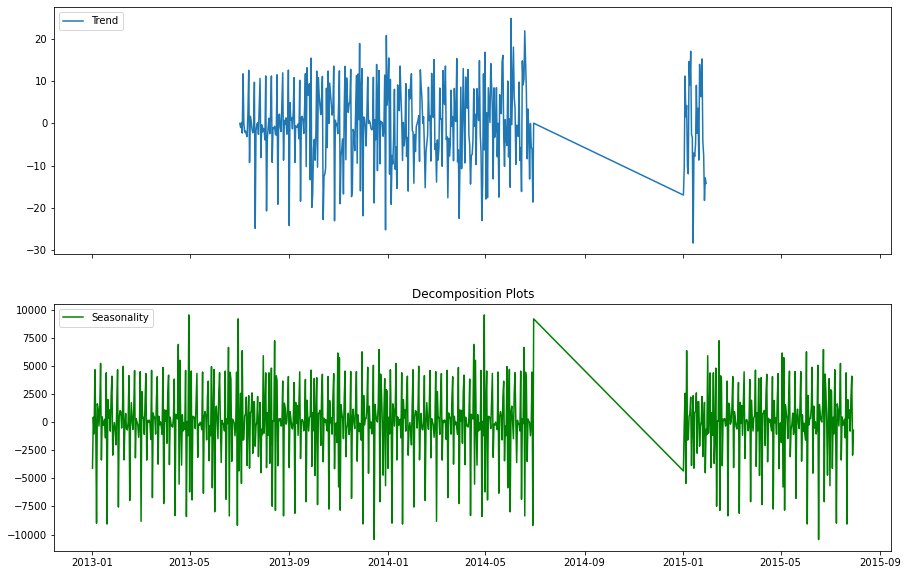

In [38]:
# Plotting seasonality and trend for store type d
plot_timeseries(sales_d,'d')

From the above plots, we cannot see that there is seasonality and trend present in our data.

## Forecasting a Time Series

### Evaluation Metrics
There are two popular metrics used in measuring the performance of regression (continuous variable) models i.e MAE & RMSE.

MAE - Mean Absolute Error: It is the average of the absolute difference between the predicted values and observed values.

RMSE - Root Mean Square Error: It is the square root of the average of squared differences between the predicted values and observed values.

MAE is easier to understand and interpret but RMSE works well in situations where large errors are undesirable. This is because the errors are squared before they are averaged, thus penalizing large errors. In our case, RMSE suits well because we want to predict the sales with minimum error (i.e penalize high errors) so that inventory can be managed properly.

So, let's choose RMSE as a metric to measure the performance of our models.

### Model 1 - SARIMA (Seasonal Autoregressive Integrated Moving Average)
In order to use this model, we need to first find out values of p, d and q. 
p represents number of Autoregressive terms - lags of dependent variable.
q represents number of Moving Average terms - lagged forecast errors in prediction equation.
d represents number of non-seasonal differences.

To find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots. 

ACF - measure of correlation between time series with a lagged version of itself. 
PACF - measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

p value is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.
q value is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.

Now, let's plot these graphs.

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [40]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(timeseries):
    
    sales0 = timeseries.copy()
    
    sales = pd.DataFrame(sales0.diff()).dropna()
    
    ACF = plot_acf(sales,lags=50)
    PACF = plot_pacf(sales,lags=50)

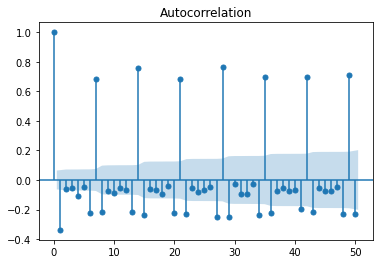

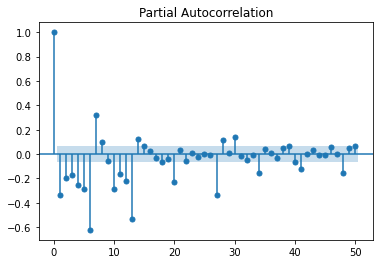

In [41]:
# ACF and PACF for store type a
auto_corr(sales_a)

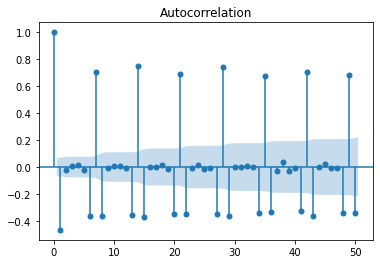

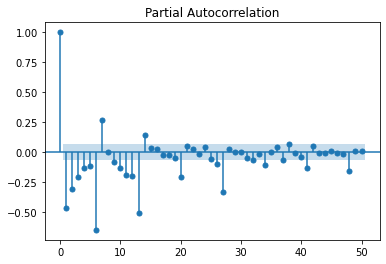

In [42]:
# ACF and PACF for store type b
auto_corr(sales_b)

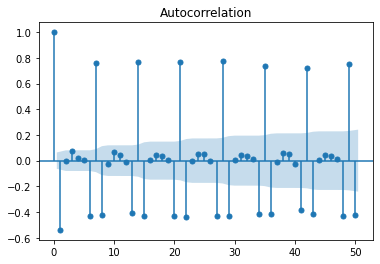

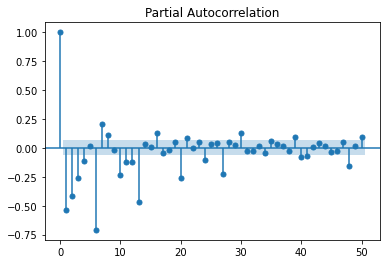

In [43]:
# ACF and PACF for store type c
auto_corr(sales_c)

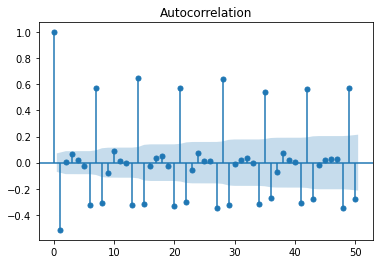

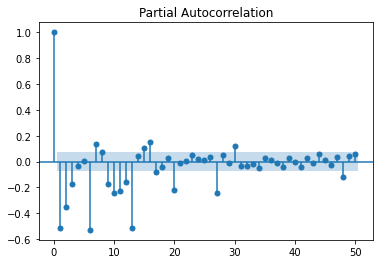

In [44]:
# ACF and PACF for store type d
auto_corr(sales_d)



If we are to predict the sales of each store, we need to consider the whole data set rather than one store of each category. We took one store of each category to understand the tiem series data but from now on, we'll use the whole dataset for modelling.

In [45]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314.0,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995.0,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822.0,559,1,1,0,1,2015,7,31,31,8.626118


In [46]:
# Summing sales on per day basis

train_arima = pd.DataFrame(train.resample("D").Sales.sum())
train_arima.head()

,Sales
Date,
2013-01-01,97235.0
2013-01-02,6949829.0
2013-01-03,6347820.0
2013-01-04,6638954.0
2013-01-05,5951593.0


In [47]:
train_arima = train_arima.dropna()

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  942
Model:                     ARMA(6, 1)   Log Likelihood              -15284.825
Method:                       css-mle   S.D. of innovations        2692464.431
Date:                Tue, 01 Feb 2022   AIC                          30587.649
Time:                        18:46:39   BIC                          30631.281
Sample:                    01-01-2013   HQIC                         30604.280
                         - 07-31-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.235e+06   5.67e+04    109.973      0.000    6.12e+06    6.35e+06
ar.L1.Sales    -0.6391      0.034    -18.873      0.000      -0.705      -0.573
ar.L2.Sales    -0.1180      0.035     -3.414    

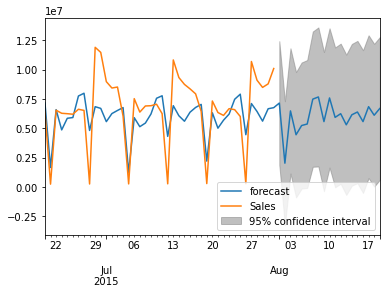

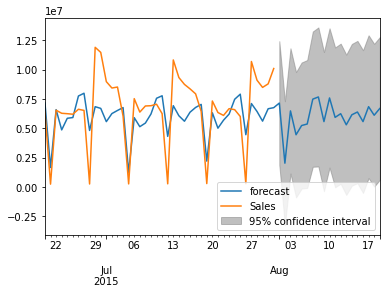

In [48]:
# Fitting the data to SARIMA model 
model_arima = ARIMA(train_arima,
                                order=(6,0,1))


result = model_arima.fit()

print(result.summary())

result.plot_predict(900,960)

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


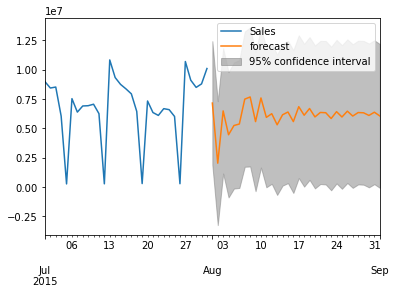

In [52]:
import statsmodels.api as sm

train_arima.index = pd.date_range(start='2013-01-01', end='2015-07-31')

res = sm.tsa.ARIMA(train_arima, (6,0,1)).fit()

fig, ax = plt.subplots()

ax = train_arima.loc['2015-07-01':].plot(ax=ax)
fig = res.plot_predict('2015-08-01', '2015-09-01', dynamic=True, ax=ax,
                        plot_insample=False)
plt.show()

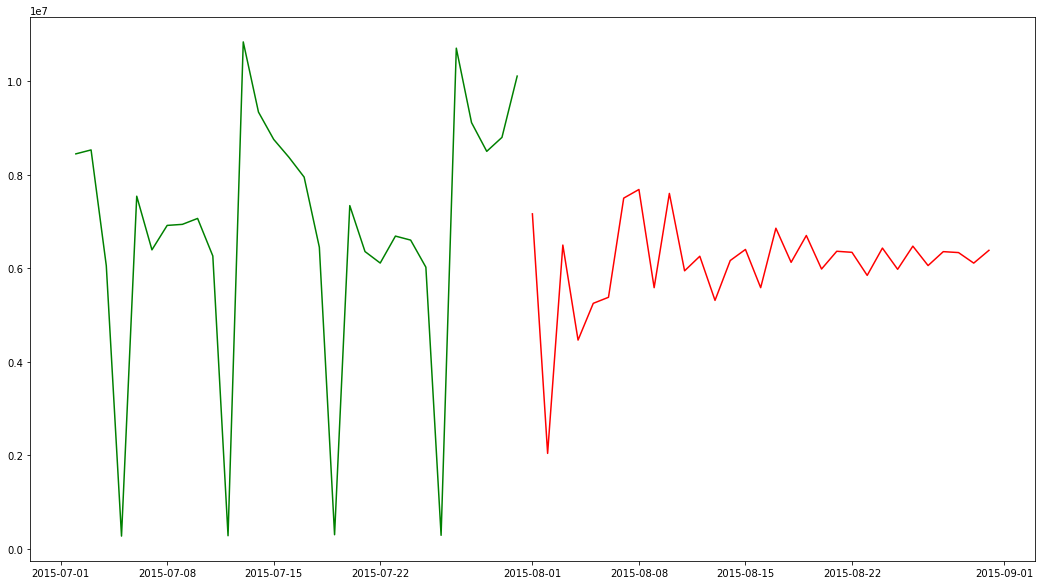

In [50]:
predictions = result.predict(len(train_arima),len(train_arima)+30)

plt.figure(figsize=(18,10))
plt.plot(predictions,color='r')
plt.plot(train_arima[-30:],color='g')

#### Reflection
- The most interesting thing about the project was that the category of stores having the highest sales don't have the highest sale per customer. It might be because those stores sell small items, which are needed on a daily basis.

- Another interesting thing was that running a promotion for the second time doesn't help in increasing sales. It is probably because customers already purchased whatever they wanted during the first promotional sale.

#### Improvement Areas: 
- We could have used the tranformation techniques to smoothen the data e.g using Moving Average, Log transformation etc. to remove seasonality and trend and make the time series more stationary. After building the model, we would have introduced the behavior of seasonality and trend back to the results. This might have resulted in a better model with a lower RMSE.


- We could also use SARIMAX model that take exogenous variables. These are the variables whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it. For example, Competition Open, Promo Open, etc.
